In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import CCXGate, CXGate
from numpy import matmul, kron, sqrt, sin, cos, pi, array
from numpy.linalg import norm
%matplotlib inline

# The CHSH Game
Named after its authors -- John Clauser, Michael Horne, Abner Shimony, and Richard Holt. 

### Nonlocal games
A nonlocal game is *cooperative game* where two players, Alice and Bob, work together to achieve an outcome. The game is run by a *referee*. An instance of a referee is equivalent to an instance of a game. It has the following rules
* Once the game starts *Alice and Bob cannot communicate*
* Before the game Alice and Bob can agree on a strategy
* The referee asks Alice and Bob a question where $x$ is Alice's question and $y$ is Bob's question
    * The referee uses randomness to select the question. I.e there is some $P((x, y) = (x', y'))$ for all potential $(x', y')$.
* Alice and Bobs responses are $a$ and $b$ respectively
* The referee then decieds whether or not Alice and Bob won based on their response $(a, b)$.
This is shown by 
![title](CHSH_Game/nonlocal-game.png)

### CHSH Game Description
1. The questions and answers are all bits $x, y, a, b \in \{0, 1\}$.
2. The referee chooses the question $(x, y)$ uniformly at random. So $P((x, y) = (x', y')) = \frac{1}{4}$
3. The answers $(a, b)$ win for the questions $(x, y)$ if $a\oplus b = x \land y$ and lose otherwise so that gives us 
    - They win if the exclusive-or of their answer if equal to the and of the their questionws.

| $(x, y)$ | win       | lose      |  why win                                 |
|----------|-----------|-----------|------------------------------------------|
| $(0, 0)$ | $a = b$   | $a \ne b$ | $0 \land 0 = 0 = a \oplus a = a\oplus b$ |
| $(0, 1)$ | $a = b$   | $a \ne b$ | $0 \land 1 = 0 = a \oplus a = a\oplus b$ |
| $(1, 0)$ | $a = b$   | $a \ne b$ | $1 \land 0 = 0 = a \oplus a = a\oplus b$ |
| $(1, 1)$ | $a \ne b$ | $a = b$   | $1 \land 1 = 1 = a \oplus b$             |


### Deterministic Strategy
We will write Alice and Bobs answers as functions of $x$ and $y$. i.e $a(x)$ and $b(y)$ are their answers for their questions. 

There is no strategy that wins every time. We can see this by checking every method. We see that they can win at most $\frac{3}{4}$ of the time. This is quite an easy strategy of just always both answering with 1 or with 0. 

### Required Vectors and Matrices for Quantum Strategy
$$
\ket{\psi_\theta} = \cos{\theta}\ket{0} + \sin{\theta}\ket{1}
$$
These gives some useful results
$$
\ket{\psi_0} = \ket{0} \\
\ket{\psi_{\pi/2}} = \ket{1} \\
\ket{\psi_{\pi/4}} = \ket{+} \\
\ket{\psi_{-\pi/4}} = \ket{-} \\
\ket{\psi_{-\pi/8}} = \frac{\sqrt{2 + \sqrt{2}}}{2}\ket{0} - \frac{\sqrt{2 - \sqrt{2}}}{2}\ket{1} \\
\ket{\psi_{\pi/8}} = \frac{\sqrt{2 + \sqrt{2}}}{2}\ket{0} + \frac{\sqrt{2 - \sqrt{2}}}{2}\ket{1} \\
\ket{\psi_{3\pi/8}} = \frac{\sqrt{2 - \sqrt{2}}}{2}\ket{0} + \frac{\sqrt{2 + \sqrt{2}}}{2}\ket{1} \\
\ket{\psi_{5\pi/8}} = -\frac{\sqrt{2 - \sqrt{2}}}{2}\ket{0} + \frac{\sqrt{2 + \sqrt{2}}}{2}\ket{1} 
$$
It is not obvious why these are useful yet. 

We also note this useful formula for the inner product of two of these vector
$$
\braket{\psi_\alpha|\psi_\beta} = \cos(\alpha)\cos(\beta)  + \sin(\alpha)\cos(\beta) = \cos(\alpha - \beta)
$$

Similarly, if we compute the inner product of the tensor of two $\psi_\theta$ vectors with $\ket{\phi^+}$ we get 
$$
\braket{\psi_\alpha \otimes \psi_\beta | \phi^+} = \frac{\cos(\alpha - \beta)}{\sqrt{2}}
$$

Now we define the unitary matrix $U_\theta$ as 
$$
U_0 = \ket{0}\braket{\psi_\theta|+|1}\bra{\psi_{\theta + \pi/2}}
$$
Intuitively this maps $\psi_\theta$ to $\ket{0}$ and $\psi_{\theta + \pi/2}$ to $\ket{1}$.

This is an example of a *rotation matrix* and it rotates two-d vectors with real number entries by an angle of $-\theta$ We can right it in the standard rotational form as 
$$
U_\theta = R_y(-2\theta) = 
\begin{pmatrix}
\cos(\theta/2) & -\sin(\theta/2) \\
\sin(\theta/2) & \cos(\theta/2)
\end{pmatrix}
$$

In [5]:
ket1 = Statevector.from_label("1")
ket0 = Statevector.from_label("0")
def ket_psi_theta(theta):
    return Statevector([cos(theta), sin(theta)])

def ket_times_bra(v1, v2):
    return Operator(matmul(array([v1]).T, array([v2])))

def U_theta(theta):
    first = ket_times_bra(ket0, ket_psi_theta(theta))
    second = ket_times_bra(ket1, ket_psi_theta(theta + (pi/2)))
    return Operator(first + second)
display(U_theta(0).draw("latex"))



<IPython.core.display.Latex object>

### Describing the Quantum Strategy
* Alice and Bob start the game sharing one ebit $AB$ in state $\ket{\psi^+}$.
* For Alice
    * If her question $x = 0$ she applies $U_0$ to $A$
    * If her question is $x = 1$ she applies $U_{\pi/4}$ to $A$
* For Bob
    * If his quesiton is $y = 0$ he applies $U_{\pi/8}$ to $B$
    * If his question is $y = 1$ he applies $U_{-\pi/8}$ to $B$

In [45]:
# Assumed Questions
x = 0
y = 1
I = Operator.from_label("I")
AB = Statevector([0, 1/sqrt(2), 1/sqrt(2), 0])
AB = Statevector([1/sqrt(2), 0, 0, 1/sqrt(2)])
# Alices turn
if x == 0:
    AB = AB.evolve(I ^ U_theta(0))
else:
    AB = AB.evolve(I ^ U_theta(pi/4))

# Bobs Turn
if y == 0:
    AB = AB.evolve(I ^ U_theta(pi/8))
else:
    AB = AB.evolve(I ^ U_theta(-pi/8))
display(AB.draw("latex"))
display(AB.probabilities_dict())
def probability_victory(x, y, v):
    prob_w = 0
    probs = v.probabilities_dict()
    for key in probs:
        first = bool(x) and bool(y)
        second = bool(int(key[0])) ^ bool(int(key[1]))
        if first == second:
            prob_w += probs[key]
    return prob_w
AB.probabilities_dict().keys
display(probability_victory(x, y, AB))

<IPython.core.display.Latex object>

{'00': 0.42677669529663675,
 '01': 0.07322330470336316,
 '10': 0.07322330470336309,
 '11': 0.42677669529663675}

0.8535533905932735

In [46]:
# Required imports

from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from numpy import pi
from numpy.random import randint

In [47]:
# Now lets do it with a circuit and a Rotation matrix
def chsh_game(strategy):
    """
    strategy: is a function that takes 2 bits as ints and returns two bits as ints. 
    Return 1 for a win, 0 for a loss
    """
    # randomly chosen x and y
    x, y = randint(0, 2), randint(0, 2)

    # use the strategy to get a, b
    a, b = strategy(x, y)
    if (a != b) == (x & y):
        return 1
    return 0

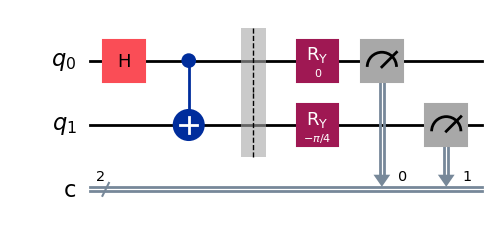

In [49]:
def chsh_circuit(x, y):
    qc = QuantumCircuit(2, 2)
    # put in phi+ state
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-pi/2, 0)
    qc.measure(0, 0)

    #Bob
    if y == 0:
        qc.ry(-pi/4, 1)
    else:
        qc.ry(pi/4, 1)
    qc.measure(1, 1)

    return qc

display(chsh_circuit(0, 0).draw("mpl"))

In [54]:
sampler = Sampler()

def quantum_strategy(x, y):
    results = sampler.run(chsh_circuit(x, y), shots=1).result()
    statistics = results.quasi_dists[0].binary_probabilities()
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]
    return a, b

In [55]:
NUM_GAMES = 1000
TOTAL_SCORE = 0
for i in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won: ",  TOTAL_SCORE / NUM_GAMES)

Fraction of games won:  0.853
